In [3]:
import pandas as pd
import pvlib
import matplotlib.pyplot as plt

# 1. Configuration: Define Location (Wuhan)
lat, lon = 30.59, 114.30
tz = 'Asia/Shanghai'
location = pvlib.location.Location(lat, lon, tz=tz, name='Wuhan')

# 2. Load TMY Weather Data
try:
    weather = pd.read_csv('data/raw/wuhan_tmy.csv', index_col=0, parse_dates=True)
    print("Weather data loaded successfully.")
except FileNotFoundError:
    print("Error: Weather file not found.")

Weather data loaded successfully.


In [4]:
# 3. System Geometry Setup

# Surface Tilt: The angle from horizontal (0 = flat, 90 = vertical)
# Optimization Rule: For fixed systems, tilt ≈ latitude is a good starting point.
surface_tilt = 30  # degrees

# Surface Azimuth: The compass direction the panel faces
# Convention: North=0, East=90, South=180, West=270
surface_azimuth = 180  # degrees (Facing South)

print(f"Tilt={surface_tilt}°, Azimuth={surface_azimuth}°")

Tilt=30°, Azimuth=180°


In [5]:
# 4. Calculate Solar Position

# Determine where the sun is in the sky for every hour of the year.
solar_position = location.get_solarposition(times=weather.index)

# apparent_zenith: Angle from directly overhead (0=overhead, 90=horizon)
# azimuth: Compass direction of the sun (180=South)
print(solar_position[['apparent_zenith', 'azimuth']].head())

                           apparent_zenith     azimuth
time(UTC)                                             
1990-01-01 00:00:00+00:00        83.190834  121.808545
1990-01-01 01:00:00+00:00        72.870410  131.088424
1990-01-01 02:00:00+00:00        64.029318  142.469959
1990-01-01 03:00:00+00:00        57.442459  156.376449
1990-01-01 04:00:00+00:00        53.964296  172.551585


In [6]:
# 5. Calculate Plane of Array (POA) Irradiance

# Calculate how much sunlight actually lands on our tilted solar panels.
poa_irradiance = pvlib.irradiance.get_total_irradiance(
    surface_tilt=surface_tilt,
    surface_azimuth=surface_azimuth,
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth'],
    dni=weather['dni'],
    ghi=weather['ghi'],
    dhi=weather['dhi']
)

# 'poa_global' is the key column: Total energy (W/m^2) hitting the panel
print(poa_irradiance[['poa_global', 'poa_direct', 'poa_diffuse']].head())

                           poa_global  poa_direct  poa_diffuse
time(UTC)                                                     
1990-01-01 00:00:00+00:00  274.849482  192.189396    82.660086
1990-01-01 01:00:00+00:00  319.431264  146.448682   172.982582
1990-01-01 02:00:00+00:00  448.993384  223.525917   225.467467
1990-01-01 03:00:00+00:00  503.172559  253.977120   249.195438
1990-01-01 04:00:00+00:00  544.374970  285.233362   259.141608


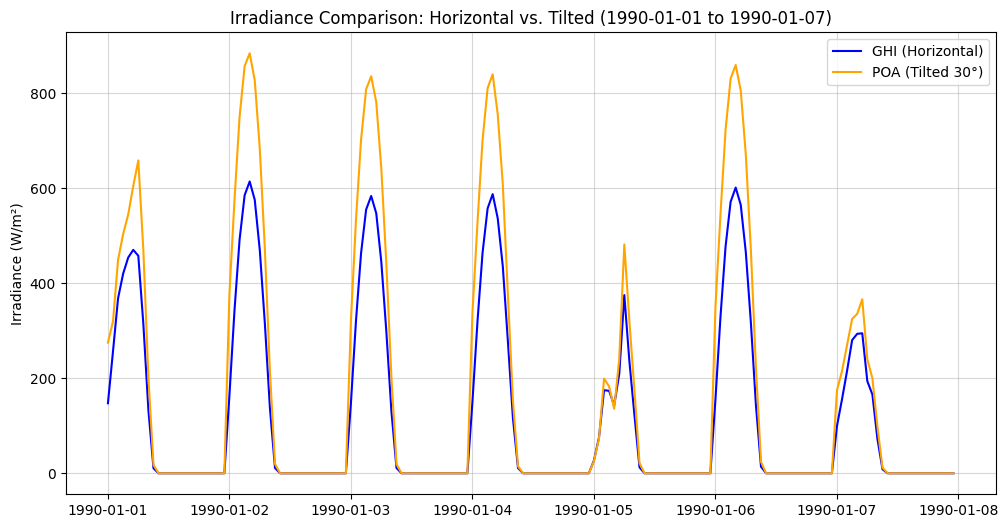

In [8]:
# 6. Visualization (GHI vs POA)

# Compare sunlight on the ground (GHI) vs. on our tilted panel (POA)
# Winter is where tilt makes the biggest difference!
start_date = '1990-01-01'
end_date = '1990-01-07'

# Slicing the dataframes
subset_weather = weather.loc[start_date:end_date]
subset_poa = poa_irradiance.loc[start_date:end_date]

# Plotting
plt.figure(figsize=(12, 6))

# Plot GHI (The baseline)
plt.plot(subset_weather.index, subset_weather['ghi'], label='GHI (Horizontal)', color='blue')

# Plot POA (Your optimized system)
plt.plot(subset_poa.index, subset_poa['poa_global'], label='POA (Tilted 30°)', color='orange')

# Decorating the plot
plt.title(f'Irradiance Comparison: Horizontal vs. Tilted ({start_date} to {end_date})')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()